# Customer Segmentation (modelisation)
Pierre-Yves BOISBUNON - January 2018

----------
In this notebook, we will continue the customer segmentation job to establish a classification model.

Tags:
- HyperOpt
- RandomForestClassfier
- XGBoostClassifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from __future__ import division
import utils

# 1 Import clean dataset

First open previously stored cleaned dataset:

In [2]:
df = pd.read_csv('segmented_rfm.csv', sep='\t')
df.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,qty_mean,qty_min,qty_max,unitprice_mean,unitprice_max,unitprice_min,totalprice_mean,totalprice_max,totalprice_min,category
0,0,1,0,1,0,0,1,7.648649,1,24,4.441622,0.65,29.95,18.760811,7.80,47.70,7
1,0,0,0,0,0,0,1,8.600000,1,25,3.936333,0.10,18.00,19.424333,2.50,72.00,0
2,1,0,0,0,1,0,0,8.166667,2,24,4.735000,1.25,18.00,23.612333,7.65,68.00,0
3,0,0,1,1,1,0,0,14.683417,1,120,4.012563,0.21,18.00,24.606332,4.68,131.40,3
4,0,0,1,0,0,0,0,11.000000,1,25,3.700909,0.42,18.00,15.777273,10.50,23.25,5


Let's define a random state in order models are computed with the same values.

In [3]:
# Random state in order to force computation with the same results
random_state = 1

Let's define the X and y vectors

In [4]:
from sklearn import cluster, metrics
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(df[df.columns[:-1]])
X_norm = scaler.transform(df[df.columns[:-1]])
y = df.as_matrix([df.columns[-1]])
y = y.flatten()

Let's also split X and y vectors perserving percentages of each classes

In [5]:
np.unique(y)

array([0, 3, 5, 7], dtype=int64)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y,
                                                    stratify=y,
                                                    random_state=random_state, 
                                                    test_size=0.2)

In [7]:
import collections
collections.Counter(y_train)

Counter({0: 1108, 5: 789, 7: 661, 3: 706})

In [8]:
collections.Counter(y_test)

Counter({3: 176, 7: 165, 5: 198, 0: 277})

## 1.1 Utils functions

Let's define the  **plot_confusion_matrix** function used later in the notebook:

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's define the  **plot_learning_curve** function used later in the notebook:

In [10]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                       scoring=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 2 Modelisation

For the modelisation, we wil use two different classifiers:
- Random Forest classifier
- XGBoost classifier

## 2.1 RandomForest

In order to optimize Random Forest model, we will optimize the model in 5 steps:
- Step 1: Setup number of estimators.
- Step 2: Setup bootstrap feature.
- Step 3: Setup max depth (node number).
- Step 4: Setup best number of features.
- Step 5: Setup best split point.

### 2.1.1 Tune n_estimators

In [13]:
from hyperopt import hp, tpe, Trials, fmin, space_eval
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold

In [14]:
from sklearn.ensemble import RandomForestClassifier

space = {}
space['n_estimators'] = hp.choice('n_estimators', [100, 500, 1000])

def objective(params):
    model_rfc = RandomForestClassifier(random_state=random_state)
    model_rfc.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_rfc, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.9412485361872983, params: {'n_estimators': 500}
train_score: 1.0, test_score: 0.941321210638989, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.9427621736376537, params: {'n_estimators': 100}
train_score: 1.0, test_score: 0.9427621736376537, params: {'n_estimators': 100}
train_score: 1.0, test_score: 0.9427621736376537, params: {'n_estimators': 100}


In [15]:
best_params = space_eval(space, best)
best_params

{'n_estimators': 100}

### 2.1.2 Tune bootstrap and criterion

In [16]:
from sklearn.ensemble import RandomForestClassifier

space = {}
space['bootstrap'] = hp.choice('bootstrap', [True, False])
space['criterion'] = hp.choice('criterion', ["gini", "entropy"])

def objective(params):
    model_rfc = RandomForestClassifier(n_estimators = 100, random_state=random_state)
    model_rfc.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_rfc, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9447274490372383, params: {'bootstrap': False, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.9447274490372383, params: {'bootstrap': False, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.9427621736376537, params: {'bootstrap': True, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.944689818665857, params: {'bootstrap': True, 'criterion': 'entropy'}
train_score: 1.0, test_score: 0.9447274490372383, params: {'bootstrap': False, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.9427621736376537, params: {'bootstrap': True, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.9471759298971497, params: {'bootstrap': False, 'criterion': 'entropy'}
train_score: 1.0, test_score: 0.9471759298971497, params: {'bootstrap': False, 'criterion': 'entropy'}
train_score: 1.0, test_score: 0.9427621736376537, params: {'bootstrap': True, 'criterion': 'gini'}
train_score: 1.0, test_score: 0.9447274490372383, params: {'bootstrap': False, 'criterion': 'gin

{'bootstrap': False, 'criterion': 'entropy'}

### 2.1.3 Tune max_depth

In [17]:
from sklearn.ensemble import RandomForestClassifier

space = {}
space['max_depth'] = hp.choice('max_depth', [3, 10, 15, 20, 30, None])

def objective(params):
    model_rfc = RandomForestClassifier(n_estimators = 100, 
                                       bootstrap = False,
                                       criterion = 'entropy',
                                       random_state=random_state)
    model_rfc.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_rfc, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9475403493624986, params: {'max_depth': 20}
train_score: 1.0, test_score: 0.9471759298971497, params: {'max_depth': 30}
train_score: 1.0, test_score: 0.9471759298971497, params: {'max_depth': None}
train_score: 0.9354764718155302, test_score: 0.9325382864461412, params: {'max_depth': 3}
train_score: 1.0, test_score: 0.9471759298971497, params: {'max_depth': None}
train_score: 0.9354764718155302, test_score: 0.9325382864461412, params: {'max_depth': 3}
train_score: 1.0, test_score: 0.9449065720672156, params: {'max_depth': 15}
train_score: 0.9354764718155302, test_score: 0.9325382864461412, params: {'max_depth': 3}
train_score: 1.0, test_score: 0.9449065720672156, params: {'max_depth': 15}
train_score: 1.0, test_score: 0.9471759298971497, params: {'max_depth': None}


{'max_depth': 20}

### 2.1.4 Tune max_features

In [18]:
from sklearn.ensemble import RandomForestClassifier

space = {}
space['max_features'] = hp.choice('max_features', ['auto', 'sqrt', 'log2', None])

def objective(params):
    model_rfc = RandomForestClassifier(
        n_estimators = 100, 
        random_state=random_state,
        bootstrap=False,
        criterion='entropy',
        max_depth=20)
    model_rfc.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_rfc, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'auto'}
train_score: 1.0, test_score: 0.9398930793713915, params: {'max_features': None}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'log2'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'auto'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'auto'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'log2'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'auto'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'log2'}
train_score: 1.0, test_score: 0.9475403493624986, params: {'max_features': 'auto'}
train_score: 1.0, test_score: 0.9398930793713915, params: {'max_features': None}


{'max_features': 'auto'}

### 2.1.5 Tune max_features, min_samples_split and min_samples_leaf

In [20]:
from sklearn.ensemble import RandomForestClassifier

space = {}
space['min_samples_split'] = hp.choice('min_samples_split', [2, 3, 7])
space['min_samples_leaf'] = hp.choice('min_samples_leaf', [1, 3, 7])

def objective(params):
    model_rfc = RandomForestClassifier(
        n_estimators = 100, 
        random_state=random_state,
        bootstrap=False,
        criterion='entropy',
        max_depth=20,
        max_features='auto')
    model_rfc.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_rfc, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9449141951982805, params: {'min_samples_leaf': 1, 'min_samples_split': 3}
train_score: 0.986922678365724, test_score: 0.9425405228533025, params: {'min_samples_leaf': 7, 'min_samples_split': 2}
train_score: 0.986922678365724, test_score: 0.9425405228533025, params: {'min_samples_leaf': 7, 'min_samples_split': 3}
train_score: 0.986922678365724, test_score: 0.9425405228533025, params: {'min_samples_leaf': 7, 'min_samples_split': 2}
train_score: 1.0, test_score: 0.9449141951982805, params: {'min_samples_leaf': 1, 'min_samples_split': 3}
train_score: 1.0, test_score: 0.9475403493624986, params: {'min_samples_leaf': 1, 'min_samples_split': 2}
train_score: 1.0, test_score: 0.9449141951982805, params: {'min_samples_leaf': 1, 'min_samples_split': 3}
train_score: 0.986922678365724, test_score: 0.9425405228533025, params: {'min_samples_leaf': 7, 'min_samples_split': 2}
train_score: 1.0, test_score: 0.9449141951982805, params: {'min_samples_leaf': 1, 'min_samples_s

{'min_samples_leaf': 1, 'min_samples_split': 2}

We can see that the best **min_samples_leaf** and **min_samples_split** values are 1 and 7.
Let's observe the test score and check if we have any overfitting.

In [29]:
from sklearn.metrics import f1_score
model_rfc = RandomForestClassifier(
    n_estimators = 100, 
    random_state=random_state,
    bootstrap=False,
    criterion='entropy',
    max_depth=20,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2)
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
test_score = f1_score(y_test, y_pred, average='macro')
test_score

0.952002439574227

If we observe now the confusion matrix we can see:

In [30]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[275,   2,   0,   0],
       [  3, 154,  10,   9],
       [  0,   8, 190,   0],
       [  0,   3,   0, 162]], dtype=int64)

Normalized confusion matrix
[[0.99 0.01 0.   0.  ]
 [0.02 0.88 0.06 0.05]
 [0.   0.04 0.96 0.  ]
 [0.   0.02 0.   0.98]]


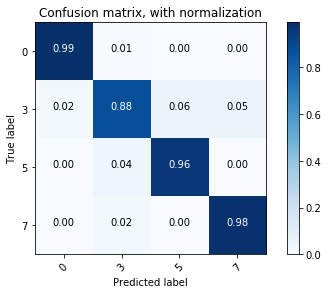

In [31]:
class_names = np.unique(y)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.grid('off')

- Some customers from class 1 are predicted either in class 2 or 0.
- Some customers from class 2 are predicted in class 1.

<module 'matplotlib.pyplot' from 'C:\\Users\\boisb\\Anaconda3\\envs\\py36\\lib\\site-packages\\matplotlib\\pyplot.py'>

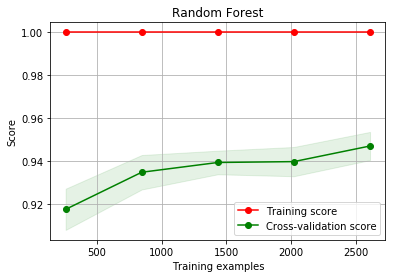

In [32]:
plot_learning_curve(model_rfc, "Random Forest",
                    X_train, y_train, train_sizes=np.linspace(.1, 1, 5), cv=5, n_jobs=-1, scoring='f1_macro')

Finaly, if we observe the learning curve from the final Random Forest, we can also see that even if can have overfitting (training score) seems closed to 1, cross validation score and test score are close.

## 2.2 XGBoost

In order to optimize XGBoost model, we will optimize the model in 5 steps:
- Step 1: Setup number of estimators.
- Step 2: Setup max depth (node number) and min_child_weight.
- Step 3: Setup gamma.
- Step 4: Setup subsample and colsample_bytree.
- Step 5: Setup regularization parameters.

### 2.2.1 Tuning n_estimators

In [36]:
import xgboost as xgb
# See http://xgboost.readthedocs.io/en/latest/parameter.html


space = {}
space['n_estimators'] = hp.choice('n_estimators', [200,400,600,800,1000])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              silent=1,
              seed=random_state)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9484130037335252, params: {'n_estimators': 800}
train_score: 1.0, test_score: 0.9481818615018616, params: {'n_estimators': 200}
train_score: 1.0, test_score: 0.9476847962935645, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.9481818615018616, params: {'n_estimators': 200}
train_score: 1.0, test_score: 0.9476847962935645, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.9490092552144496, params: {'n_estimators': 400}
train_score: 1.0, test_score: 0.9483740278766593, params: {'n_estimators': 600}
train_score: 1.0, test_score: 0.9476847962935645, params: {'n_estimators': 1000}
train_score: 1.0, test_score: 0.9484130037335252, params: {'n_estimators': 800}
train_score: 1.0, test_score: 0.9483740278766593, params: {'n_estimators': 600}


{'n_estimators': 400}

### 2.2.2 Tune max_depth and min_child_weight

In [37]:
import xgboost as xgb


space = {}
space['max_depth'] = hp.choice('max_depth', [4, 6, 8, 10])
space['min_child_weight'] = hp.choice('min_child_weight', [1, 4])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              n_estimators=400,
              silent=1,
              seed=random_state)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 1.0, test_score: 0.9466402483041778, params: {'max_depth': 10, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9457189421437249, params: {'max_depth': 6, 'min_child_weight': 4}
train_score: 1.0, test_score: 0.9456238223448518, params: {'max_depth': 8, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9479921816754924, params: {'max_depth': 8, 'min_child_weight': 4}
train_score: 1.0, test_score: 0.9479921816754924, params: {'max_depth': 8, 'min_child_weight': 4}
train_score: 1.0, test_score: 0.9456238223448518, params: {'max_depth': 8, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9466402483041778, params: {'max_depth': 10, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9466402483041778, params: {'max_depth': 10, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9475904421286607, params: {'max_depth': 4, 'min_child_weight': 1}
train_score: 1.0, test_score: 0.9479921816754924, params: {'max_depth': 8, 'min_child_weight': 4}


{'max_depth': 8, 'min_child_weight': 4}

### 2.2.3 Tune gamma

In [38]:
import xgboost as xgb

space = {}
space['gamma'] = hp.choice('max_depth', [0,0.2, 0.4, 0.6, 0.8])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              n_estimators=400,
              silent=1,
              seed=random_state,
              max_depth=8,
              min_child_weight=4)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 0.9935610386919496, test_score: 0.9492289746352796, params: {'gamma': 0.8}
train_score: 1.0, test_score: 0.9479921816754924, params: {'gamma': 0}
train_score: 1.0, test_score: 0.9479921816754924, params: {'gamma': 0}
train_score: 0.9965025163606024, test_score: 0.946763042722434, params: {'gamma': 0.6}
train_score: 0.9965025163606024, test_score: 0.946763042722434, params: {'gamma': 0.6}
train_score: 0.9999159781444741, test_score: 0.943069268976816, params: {'gamma': 0.2}
train_score: 0.9935610386919496, test_score: 0.9492289746352796, params: {'gamma': 0.8}
train_score: 0.9999159781444741, test_score: 0.943069268976816, params: {'gamma': 0.2}
train_score: 0.9987327708800666, test_score: 0.9455069878499375, params: {'gamma': 0.4}
train_score: 0.9965025163606024, test_score: 0.946763042722434, params: {'gamma': 0.6}


{'gamma': 0.8}

### 2.2.4 Tune subsample and colsample_bytree

In [39]:
import xgboost as xgb

space = {}
space['subsample'] = hp.choice('subsample', [0.7, 0.8, 0.9, 1])
space['colsample_bytree'] = hp.choice('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              n_estimators=400,
              silent=1,
              seed=random_state,
              max_depth=8,
              min_child_weight=4,
              gamma=0.8)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 0.9985452320320206, test_score: 0.9505802958770306, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
train_score: 0.9988149581321606, test_score: 0.9494859970229783, params: {'colsample_bytree': 0.8, 'subsample': 0.8}
train_score: 0.9989004460092717, test_score: 0.9505074374181375, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
train_score: 0.999419302095502, test_score: 0.9504077170772505, params: {'colsample_bytree': 1, 'subsample': 0.8}
train_score: 0.9989707631972893, test_score: 0.9506086673062482, params: {'colsample_bytree': 1, 'subsample': 0.9}
train_score: 0.998738311991595, test_score: 0.948499233728953, params: {'colsample_bytree': 0.9, 'subsample': 0.9}
train_score: 0.998738311991595, test_score: 0.948499233728953, params: {'colsample_bytree': 0.9, 'subsample': 0.9}
train_score: 0.9963257235483371, test_score: 0.9498779601900319, params: {'colsample_bytree': 0.9, 'subsample': 1}
train_score: 0.9986380682251206, test_score: 0.953023396483761, params: {'c

{'colsample_bytree': 0.8, 'subsample': 0.9}

We can see that the best **colsample_bytree** / **subsample** couple is **1/1**, it gives the best cross validation score.

### 2.2.5 Tune regularization parameters

In [40]:
import xgboost as xgb

space = {}
space['reg_alpha'] = hp.choice('reg_alpha', [0, 0.1, 0.2])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              n_estimators=400,
              silent=1,
              seed=random_state,
              max_depth=8,
              min_child_weight=4,
              gamma=0.8,
              subsample=0.8,
              colsample_bytree=0.9)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 0.9983739724653278, test_score: 0.9493846626927989, params: {'reg_alpha': 0.1}
train_score: 0.9983739724653278, test_score: 0.9493846626927989, params: {'reg_alpha': 0.1}
train_score: 0.9989757174186294, test_score: 0.9503931728598539, params: {'reg_alpha': 0}
train_score: 0.9989757174186294, test_score: 0.9503931728598539, params: {'reg_alpha': 0}
train_score: 0.9976752896469838, test_score: 0.9490296140065476, params: {'reg_alpha': 0.2}
train_score: 0.9983739724653278, test_score: 0.9493846626927989, params: {'reg_alpha': 0.1}
train_score: 0.9989757174186294, test_score: 0.9503931728598539, params: {'reg_alpha': 0}
train_score: 0.9983739724653278, test_score: 0.9493846626927989, params: {'reg_alpha': 0.1}
train_score: 0.9983739724653278, test_score: 0.9493846626927989, params: {'reg_alpha': 0.1}
train_score: 0.9976752896469838, test_score: 0.9490296140065476, params: {'reg_alpha': 0.2}


{'reg_alpha': 0}

We can see that the best **regularisation** value is **0**, it gives the best cross validation score.

### 2.2.6 Tune learning_rate

In [41]:
import xgboost as xgb

space = {}
space['learning_rate'] = hp.choice('learning_rate', [0.1, 0.3, 0.4, 0.5])

def objective(params):
    model_xgb = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.3,
              n_estimators=400,
              silent=1,
              seed=random_state,
              max_depth=8,
              min_child_weight=4,
              gamma=0.8,
              subsample=0.8,
              colsample_bytree=0.9,
              reg_alpha=0)
    model_xgb.set_params(**params)
    shuffle = KFold(n_splits=5, shuffle=False)
    score = cross_validate(model_xgb, X_train, y_train, cv=shuffle, scoring='f1_macro', n_jobs=-1)
    print('train_score: {}, test_score: {}, params: {}'.format(score['train_score'].mean(), score['test_score'].mean(), params))
    return 1-score['test_score'].mean()
        
trials = Trials()

best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best)
best_params

train_score: 0.9994216354062442, test_score: 0.9487985339333223, params: {'learning_rate': 0.4}
train_score: 0.9992436801493607, test_score: 0.9505075101867065, params: {'learning_rate': 0.5}
train_score: 0.9976606467703739, test_score: 0.9509366057674489, params: {'learning_rate': 0.1}
train_score: 0.9976606467703739, test_score: 0.9509366057674489, params: {'learning_rate': 0.1}
train_score: 0.9989757174186294, test_score: 0.9503931728598539, params: {'learning_rate': 0.3}
train_score: 0.9976606467703739, test_score: 0.9509366057674489, params: {'learning_rate': 0.1}
train_score: 0.9994216354062442, test_score: 0.9487985339333223, params: {'learning_rate': 0.4}
train_score: 0.9976606467703739, test_score: 0.9509366057674489, params: {'learning_rate': 0.1}
train_score: 0.9992436801493607, test_score: 0.9505075101867065, params: {'learning_rate': 0.5}
train_score: 0.9992436801493607, test_score: 0.9505075101867065, params: {'learning_rate': 0.5}


{'learning_rate': 0.1}

### 2.2.7 Final testing

Let's build the final classifier model based on previous XGBoost parameters optimized:

In [42]:
model = xgb.XGBClassifier(
              nthread=4,
              objective='multi:softmax',
              learning_rate=0.1,
              n_estimators=400,
              silent=1,
              seed=random_state,
              max_depth=8,
              min_child_weight=4,
              gamma=0.8,
              subsample=0.8,
              colsample_bytree=0.9,
              reg_alpha=0)

In [44]:
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
test_score = custom_scorer(y_test, y_predict)
test_score

C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9507969105321551

If we observe now the confusion matrix we can see:

Normalized confusion matrix
[[0.99 0.01 0.   0.  ]
 [0.02 0.89 0.05 0.05]
 [0.   0.04 0.96 0.  ]
 [0.   0.04 0.   0.96]]


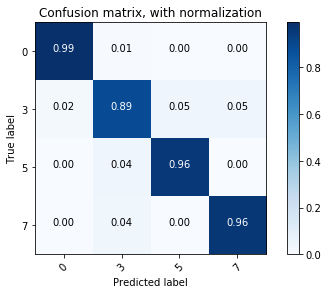

In [45]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
class_names = np.unique(y)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.grid('off')

- Some customers from class 1 are predicted either in class 2 or 0.
- Some customers from class 2 are predicted in class 1.

C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty ar

C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty ar

<module 'matplotlib.pyplot' from 'C:\\Users\\boisb\\Anaconda3\\envs\\py36\\lib\\site-packages\\matplotlib\\pyplot.py'>

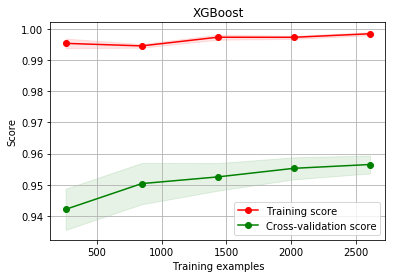

In [46]:
plot_learning_curve(model, "XGBoost",
                    X_train, y_train, train_sizes=np.linspace(.1, 1, 5),cv=5)

Finaly, if we observe the learning curve from the final XGBoost, we can also see that even if can have overfitting (training score) seems closed to 1 but as previously stated cross validation score and test score are close.

In [48]:
from sklearn.externals import joblib
joblib.dump(model, './api/static/model.pkl')
joblib.dump(scaler, './api/static/scaler.pkl')

['./api/static/scaler.pkl']

Let's store classifier and scaler for later use.